### Import Libraries


In [30]:
import numpy as np

# Import pandas
import pandas as pd

# Core scverse libraries
import scanpy as sc
import anndata as ad

# Gerard's libraries
from src.uniprot_client import UniprotClient

# Data retrieval
import pooch

# import seaborn
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import umap

from scipy.stats import fisher_exact


___
### Config

In [31]:
TRANSLATE_PROTEIN_ID = False

---
### Load the Data

In [32]:
# Load count table
data_src = "./data/raw/sasha_SI_THP/SI_THP_RAW_proteomics_data_ss.xlsx"

# Load the data
dataM1 = pd.read_excel(data_src, sheet_name="THP_M1", index_col=0) # Index = Accession
dataM2 = pd.read_excel(data_src, sheet_name="THP_M2", index_col=0) # Index = Accession

# Keep only these columns
dataM1 = dataM1[["Description", "Score", "Coverage", "# Proteins", "# Unique Peptides", "# Peptides", "# PSMs"]]
dataM2 = dataM2[["Description", "Score", "Coverage", "# Proteins", "# Unique Peptides", "# Peptides", "# PSMs"]]


/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Matrix format

* **Accession:** This is a unique identifier assigned to a protein, often from databases like UniProt or RefSeq.
* **Description:** A brief description of the protein's function or characteristics.
* **Score:** A numerical value representing the confidence level of the protein identification. Higher scores indicate more reliable identifications.
* **Coverage:** The percentage of the protein's amino acid sequence that has been covered by identified peptides.
* **#Proteins:** The number of proteins associated with the identified peptides.
* **#Unique Peptides:** The number of distinct peptide sequences identified.
* **#Peptides:** The total number of peptides identified, including duplicates.
* **#PSMs:** The number of Peptide Spectrum Matches, which represent the number of times a peptide sequence has been identified in the mass spectra.

In [33]:
if TRANSLATE_PROTEIN_ID:
    # Convert proteins to gene names
    unipcl = UniprotClient()

    
    # Get the gene names (the protein names are the index)
    gene_names = unipcl.batch_translate_protein_ids(dataM1.index)
    print(gene_names)

    # Add the gene names to the data as another column
    dataM1['Gene'] = gene_names
    


---

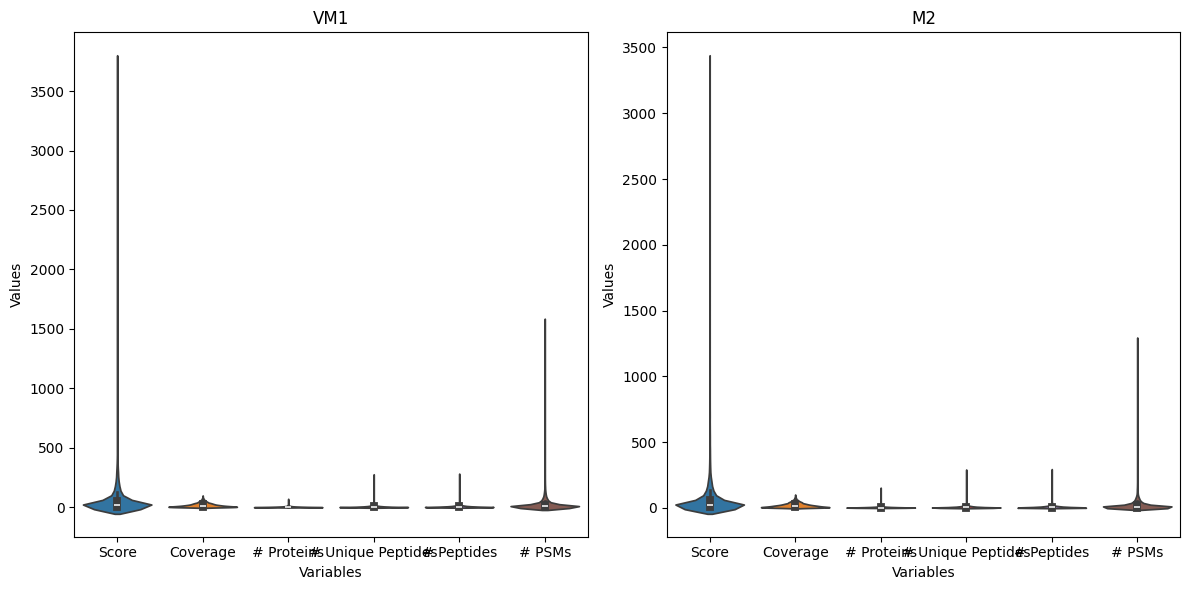

In [34]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot violin plot for M1
sns.violinplot(data=dataM1.select_dtypes(include=[np.number]), ax=axs[0])
axs[0].set_title("VM1")
axs[0].set_xlabel("Variables")
axs[0].set_ylabel("Values")

# Plot violin plot for M2
sns.violinplot(data=dataM2.select_dtypes(include=[np.number]), ax=axs[1])
axs[1].set_title("M2")
axs[1].set_xlabel("Variables")
axs[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

In [35]:
# Describe the data
print("M1")
print(dataM1.describe())

print("M2")
print(dataM2.describe())

M1
             Score     Coverage   # Proteins  # Unique Peptides   # Peptides  \
count  6187.000000  6187.000000  6187.000000        6187.000000  6187.000000   
mean     60.209782    19.106992     4.549378           6.041215     6.804105   
std     153.061528    16.815820     4.295120           8.126371     9.034068   
min       0.000000     0.070000     1.000000           0.000000     1.000000   
25%       5.102419     6.105000     2.000000           2.000000     2.000000   
50%      17.022330    13.820000     3.000000           4.000000     4.000000   
75%      55.612183    27.710000     6.000000           8.000000     9.000000   
max    3747.075588    94.740000    71.000000         276.000000   281.000000   

            # PSMs  
count  6187.000000  
mean     25.541620  
std      63.851041  
min       1.000000  
25%       2.000000  
50%       8.000000  
75%      24.000000  
max    1564.000000  
M2
             Score     Coverage   # Proteins  # Unique Peptides   # Peptides  \
coun

<Figure size 2000x1000 with 0 Axes>

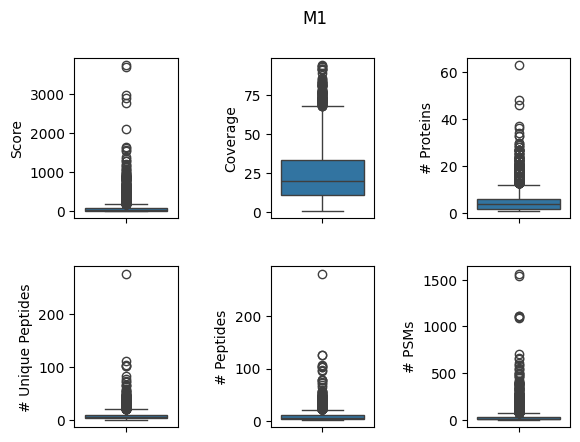

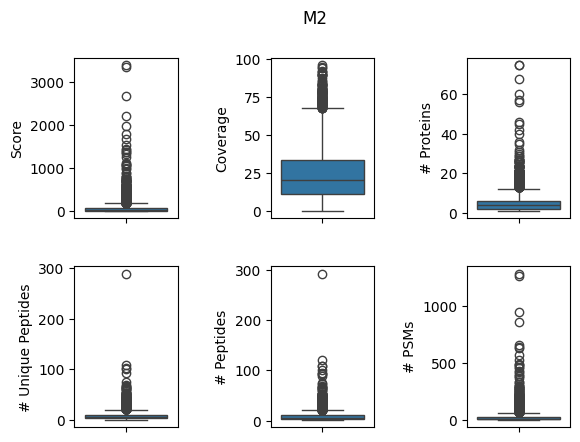

In [59]:
plt.figure(figsize=(20, 20))

# M1
fig, axs = plt.subplots(2, 3)
fig.suptitle('M1')
sns.boxplot(y=dataM1["Score"], ax=axs[0, 0])
sns.boxplot(y=dataM1["Coverage"], ax=axs[0, 1])
sns.boxplot(y=dataM1["# Proteins"], ax=axs[0, 2])
sns.boxplot(y=dataM1["# Unique Peptides"], ax=axs[1, 0])
sns.boxplot(y=dataM1["# Peptides"], ax=axs[1, 1])
sns.boxplot(y=dataM1["# PSMs"], ax=axs[1, 2])
plt.subplots_adjust(hspace=0.3, wspace=0.9)
plt.show()

# M2
fig, axs = plt.subplots(2, 3)
fig.suptitle('M2')
sns.boxplot(y=dataM2["Score"], ax=axs[0, 0])
sns.boxplot(y=dataM2["Coverage"], ax=axs[0, 1])
sns.boxplot(y=dataM2["# Proteins"], ax=axs[0, 2])
sns.boxplot(y=dataM2["# Unique Peptides"], ax=axs[1, 0])
sns.boxplot(y=dataM2["# Peptides"], ax=axs[1, 1])
sns.boxplot(y=dataM2["# PSMs"], ax=axs[1, 2])

plt.subplots_adjust(hspace=0.3, wspace=0.9)
plt.show()

In [37]:
PEPTIDE_THRESHOLD = 2

# Print the number of proteins with less than PEPTIDE_THRESHOLD peptides
print(f"Number of proteins with less than {PEPTIDE_THRESHOLD} peptides in M1: {dataM1[dataM1['# Peptides'] < PEPTIDE_THRESHOLD].shape[0]}")
print(f"Number of proteins with less than {PEPTIDE_THRESHOLD} peptides in M2: {dataM2[dataM2['# Peptides'] < PEPTIDE_THRESHOLD].shape[0]}")

# Filter out data with less than 2 peptides
dataM1 = dataM1[dataM1["# Peptides"] >= PEPTIDE_THRESHOLD]
dataM2 = dataM2[dataM2["# Peptides"] >= PEPTIDE_THRESHOLD]

Number of proteins with less than 2 peptides in M1: 1292
Number of proteins with less than 2 peptides in M2: 1374


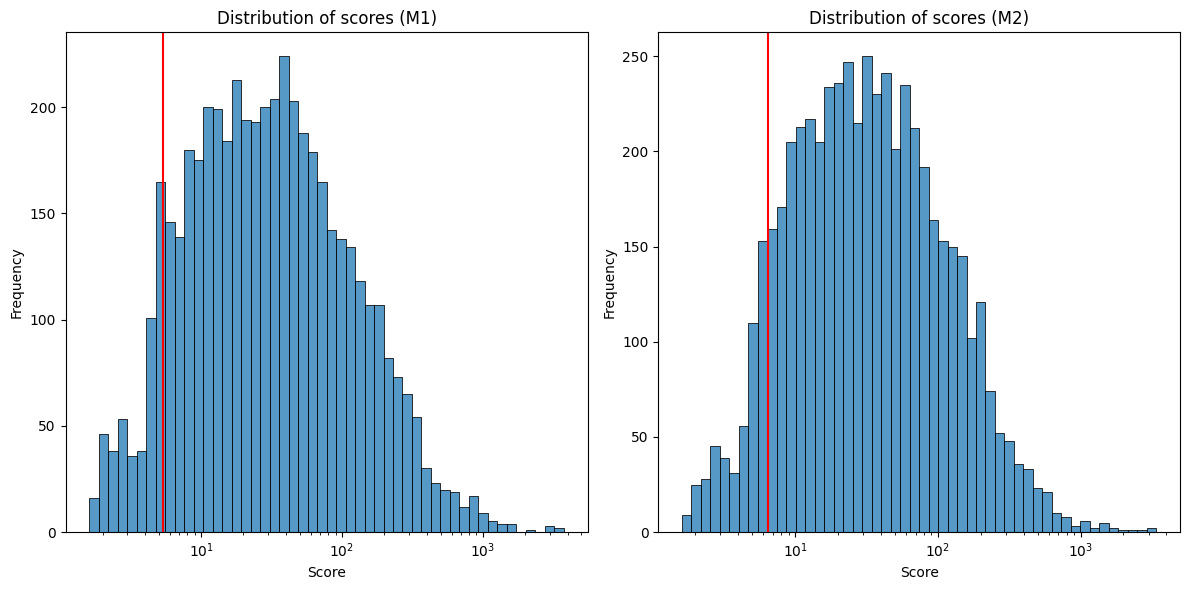

%Proteins (Score >= 5.344445466995242) (M1):  89.99%
%Proteins (Score >= 6.50436902046204) (M2):  90.00%


In [38]:
# Bottom limit for SCORE in percentage
SCORE_PCT_THRESHOLD = 10

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot dataM1
sns.histplot(dataM1['Score'], bins=50, log_scale=True, ax=axs[0])
m1_score_threshold = np.percentile(dataM1['Score'], SCORE_PCT_THRESHOLD)
axs[0].set_title("Distribution of scores (M1)")
axs[0].set_xlabel("Score")
axs[0].set_ylabel("Frequency")
axs[0].axvline(m1_score_threshold, color='red')

# Plot dataM2
sns.histplot(dataM2['Score'], bins=50, log_scale=True, ax=axs[1])
m2_score_threshold = np.percentile(dataM2['Score'], SCORE_PCT_THRESHOLD)
axs[1].set_title("Distribution of scores (M2)")
axs[1].set_xlabel("Score")
axs[1].set_ylabel("Frequency")
axs[1].axvline(m2_score_threshold, color='red')

plt.tight_layout()
plt.show()


# Percentage of proteins with a score higher than the threshold
n_proteins = dataM1.shape[0]
n_proteins_above_threshold = dataM1[dataM1['Score'] >= m1_score_threshold].shape[0]
print(f"%Proteins (Score >= {m1_score_threshold}) (M1):  {n_proteins_above_threshold/n_proteins*100:.2f}%")

n_proteins = dataM2.shape[0]
n_proteins_above_threshold = dataM2[dataM2['Score'] >= m2_score_threshold].shape[0]
print(f"%Proteins (Score >= {m2_score_threshold}) (M2):  {n_proteins_above_threshold/n_proteins*100:.2f}%")


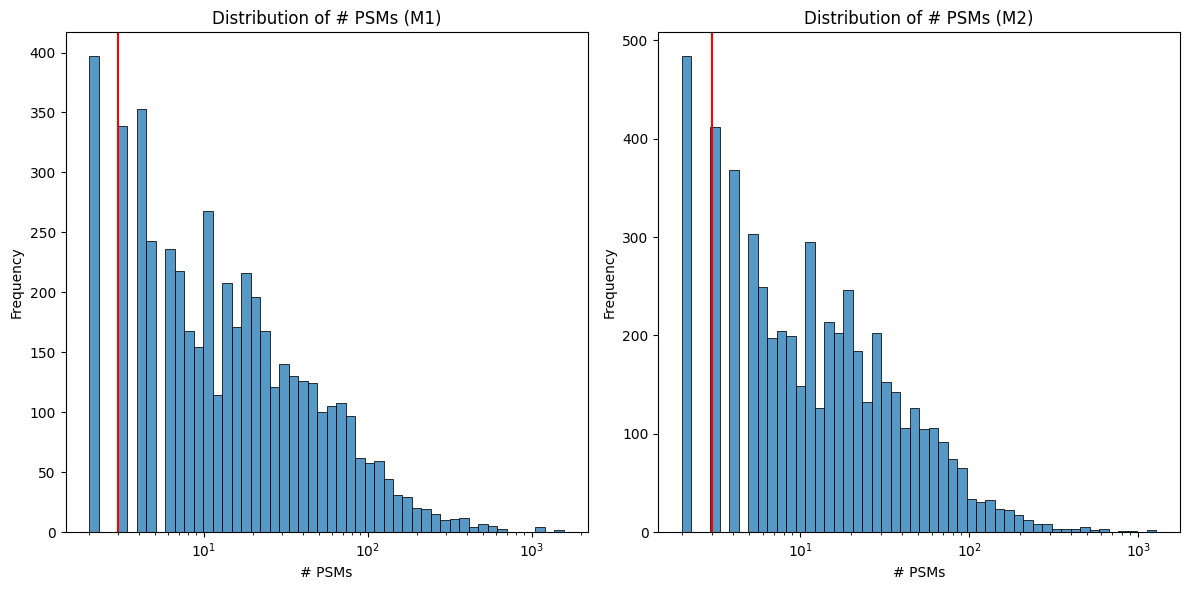

%Proteins (# PSMs >= 3.0) (M1):  91.89%
%Proteins (# PSMs >= 3.0) (M2):  90.95%


In [39]:
# Bottom limit for # PSMs in percentage
PSM_PCT_THRESHOLD = 10

# Plot the distribution of scores and # PSMs for both dataM1 and dataM2
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot dataM1 # PSMs
sns.histplot(dataM1['# PSMs'], bins=50, log_scale=True, ax=axs[0])
m1_psm_threshold = np.percentile(dataM1['# PSMs'], PSM_PCT_THRESHOLD)
axs[0].set_title("Distribution of # PSMs (M1)")
axs[0].set_xlabel("# PSMs")
axs[0].set_ylabel("Frequency")
axs[0].axvline(m1_psm_threshold, color='red')

# Plot dataM2 # PSMs
sns.histplot(dataM2['# PSMs'], bins=50, log_scale=True, ax=axs[1])
m2_psm_threshold = np.percentile(dataM2['# PSMs'], PSM_PCT_THRESHOLD)
axs[1].set_title("Distribution of # PSMs (M2)")
axs[1].set_xlabel("# PSMs")
axs[1].set_ylabel("Frequency")
axs[1].axvline(m2_psm_threshold, color='red')

plt.tight_layout()
plt.show()


# Percentage of proteins with a score higher than the threshold for both dataM1 and dataM2
n_proteins = dataM1.shape[0]
n_proteins_above_threshold = dataM1[dataM1['# PSMs'] >= m1_psm_threshold].shape[0]
print(f"%Proteins (# PSMs >= {m1_psm_threshold}) (M1):  {n_proteins_above_threshold/n_proteins*100:.2f}%")

n_proteins = dataM2.shape[0]
n_proteins_above_threshold = dataM2[dataM2['# PSMs'] >= m2_psm_threshold].shape[0]
print(f"%Proteins (# PSMs >= {m2_psm_threshold}) (M2):  {n_proteins_above_threshold/n_proteins*100:.2f}%")




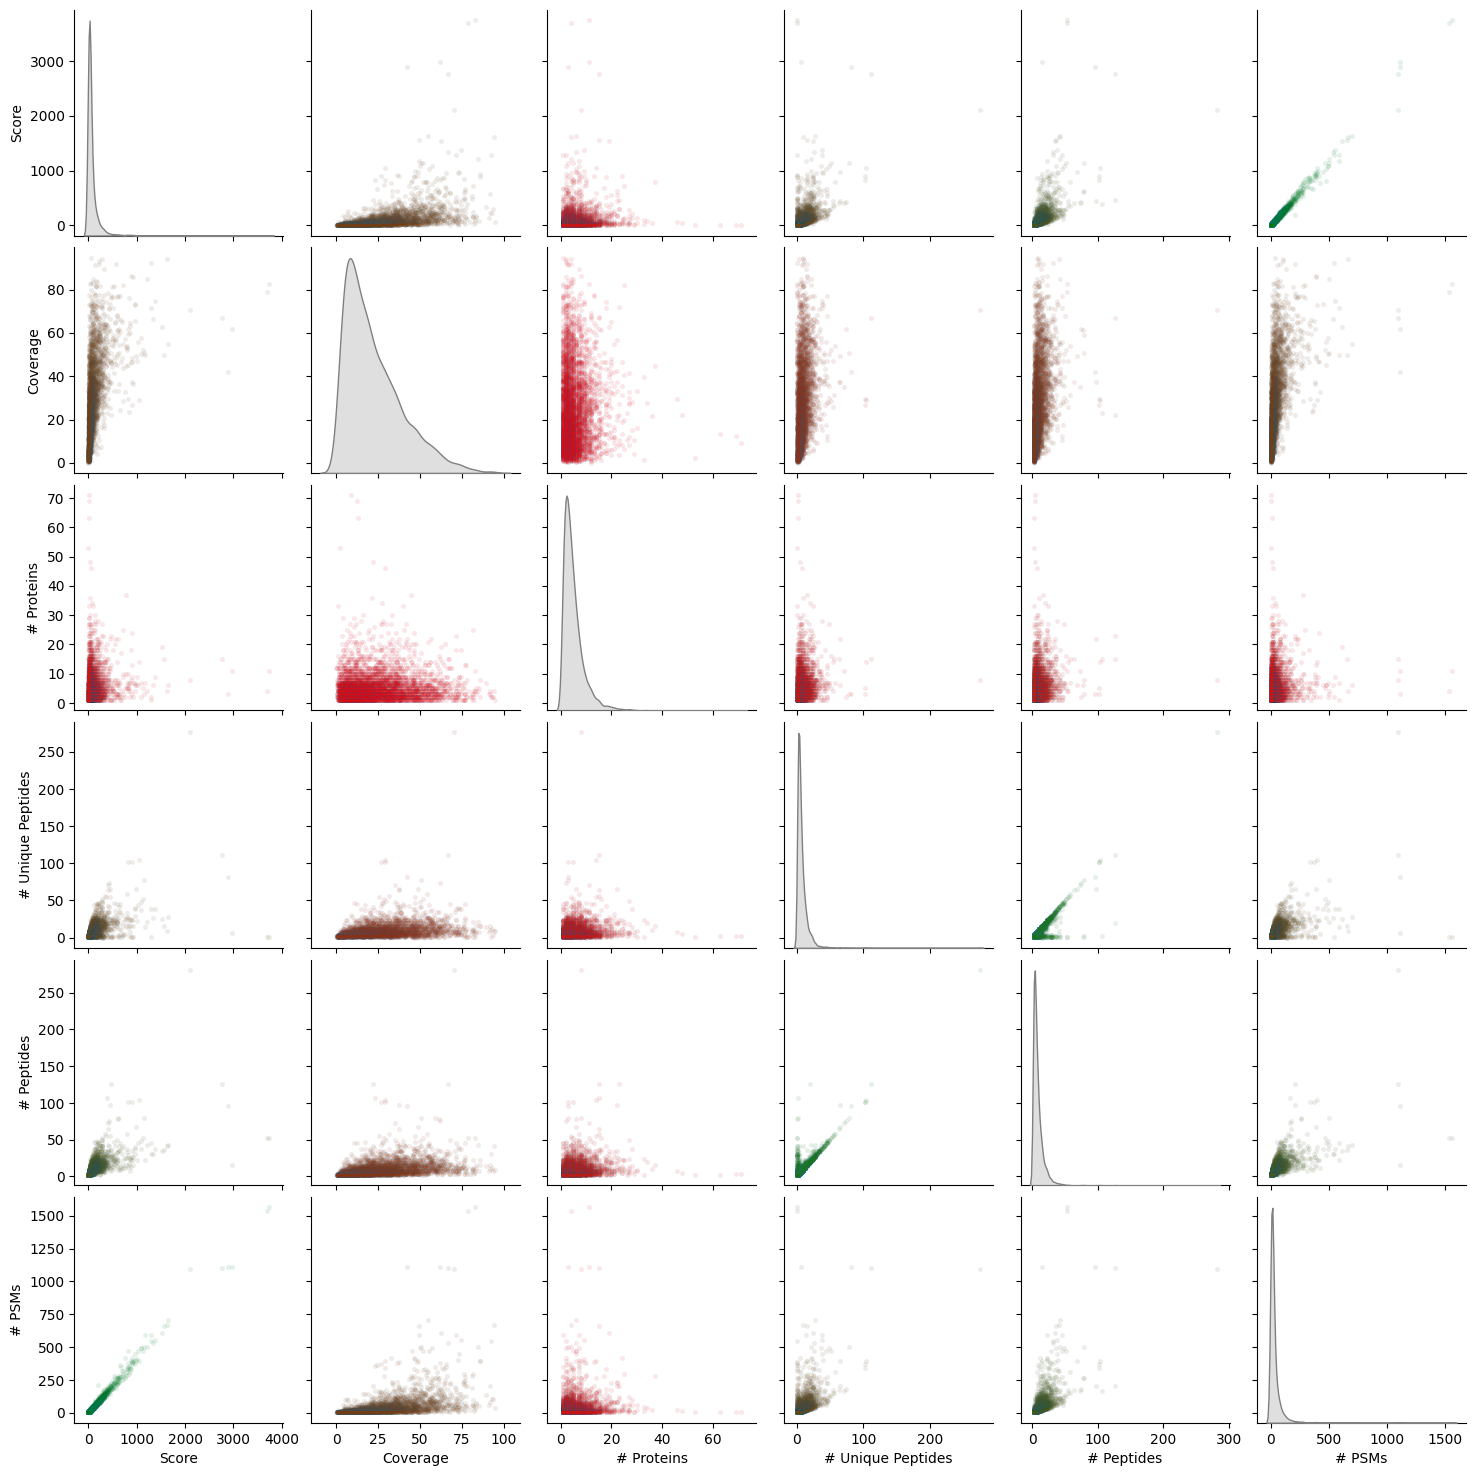

In [40]:

# Example dataset (replace with your data)
data = dataM1.drop(columns=['Description'])

# Compute pairwise correlations
correlations = data.corr().abs()  # Absolute correlation to avoid negative values

# Create a custom gradient from red to green
cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"])

# Function to get color based on correlation value
def get_color(value, cmap):
    norm_value = (value - correlations.min().min()) / (correlations.max().max() - correlations.min().min())
    return cmap(norm_value)

# do the same, but now using grey color for the diagonal
g = sns.pairplot(data, diag_kind='kde', plot_kws={'s': 10, 'alpha':0.1, 'edgecolor': None}, diag_kws={'color':'grey'})  # 's' controls dot size

# Loop through the axes to color each scatter plot
for i, j in zip(*np.triu_indices_from(correlations, 1)):
    ax = g.axes[i, j]
    corr_value = correlations.iloc[i, j]
    color = get_color(corr_value, cmap)
    
    # Apply the color gradient to all scatter plot
    ax.collections[0].set_facecolor(color)
    ax = g.axes[j, i]
    ax.collections[0].set_facecolor(color)


plt.show()




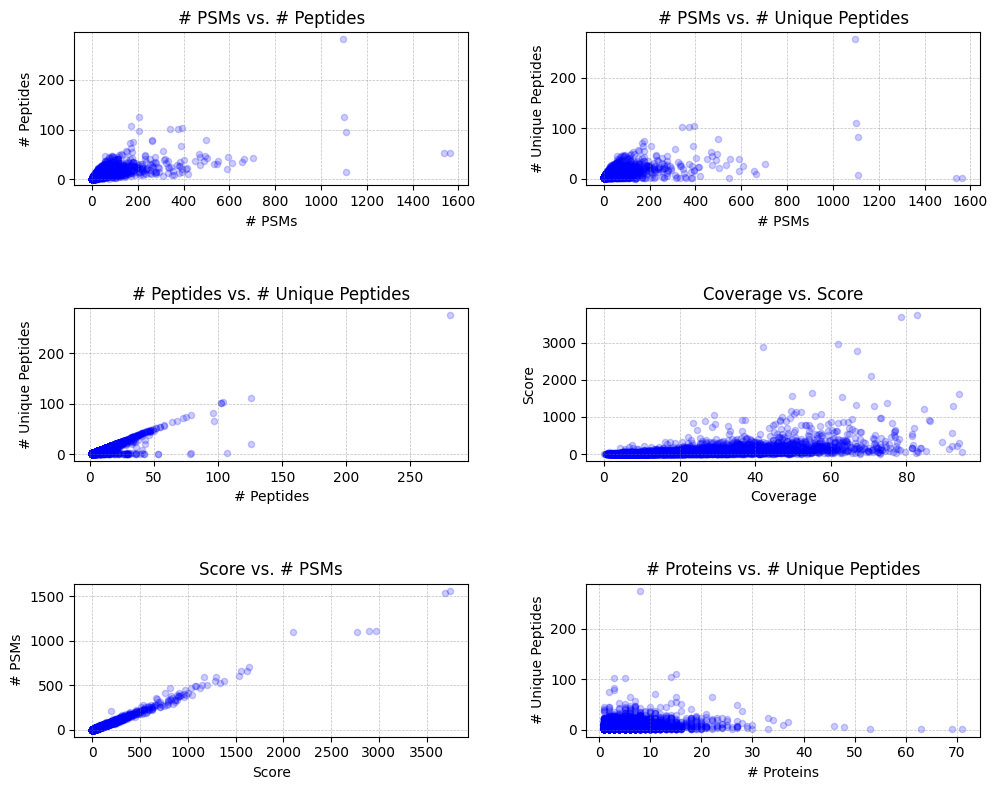

In [41]:


# Define pairs of features to plot
features_to_plot = [
    ('# PSMs', '# Peptides'),
    ('# PSMs', '# Unique Peptides'),
    ('# Peptides', '# Unique Peptides'),
    ('Coverage', 'Score'),
    ('Score', '# PSMs'), 
    ('# Proteins', '# Unique Peptides')
]

# Set grid dimensions (adjust as needed)
rows, cols = 2, 2  # Create a 2x2 grid
rows, cols = features_to_plot.__len__() // 2, 2

# Configure plot size and style outside the loop (efficiency)
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))  # Set figure size and create axes grid
point_size = 20
alpha = 0.2
marker = 'o'
color = 'blue'
grid_params = {'linestyle': '--', 'linewidth': 0.5, 'color': 'gray', 'which': 'both', 'alpha': 0.5}



# Loop through features and create plots
for i in range(rows):
    for j in range(cols):
        x_feature, y_feature = features_to_plot[i * cols + j]  # Access feature pair

        # Create the scatter plot on the current axis
        axes[i, j].scatter(dataM1[x_feature], dataM1[y_feature], s=point_size, alpha=alpha, marker=marker, c=color)

        # Set axis labels and title
        axes[i, j].set_xlabel(x_feature, fontsize=10)
        axes[i, j].set_ylabel(y_feature, fontsize=10)
        axes[i, j].set_title(f'{x_feature} vs. {y_feature}', fontsize=12)

        # Add grid lines
        axes[i, j].grid(**grid_params)

# Adjust spacing and display the plot
plt.tight_layout()
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.show()

### Consider only those proteins with Score above the Threshold 

In [42]:
dataM1 = dataM1[dataM1['Score'] >= m1_score_threshold]
dataM2 = dataM2[dataM2['Score'] >= m2_score_threshold]

### List the 100 most present proteins in both M1 and M2  *(do not work for identyfing the cell type)*
As "present" I consider those that appear more frequent in the spectra (based on PSMs)

In [43]:
TOP_NUMBER = 100

# Take the top proteins based on the PSMs value (sorted in descending order)
topM1 = dataM1.sort_values(by='# PSMs', ascending=False).head(TOP_NUMBER)
topM2 = dataM2.sort_values(by='# PSMs', ascending=False).head(TOP_NUMBER)


Number of common proteins: 83


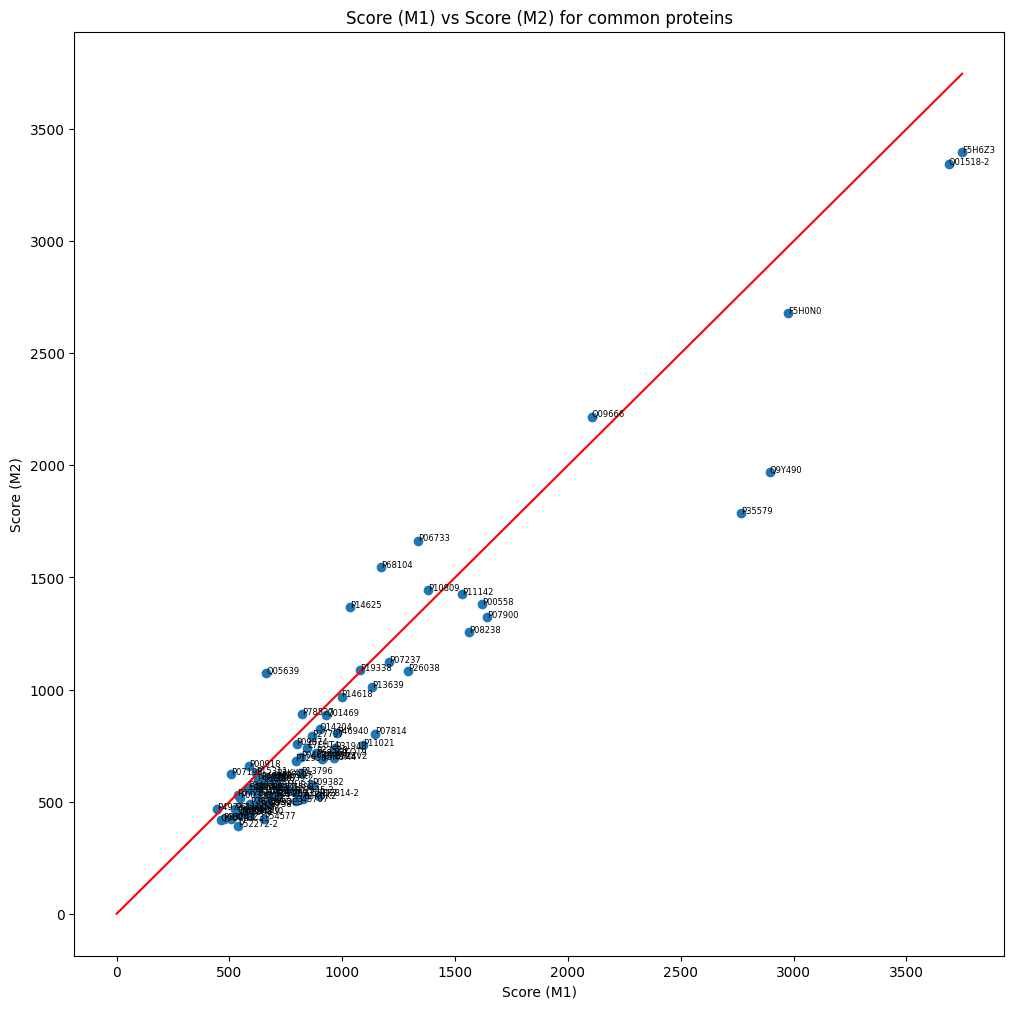

In [44]:
plt.figure(figsize=(12, 12))

# Filter the proteins present in both topM1 and topM2
common_top_proteins = topM1.index.intersection(topM2.index)
print(f"Number of common proteins: {len(common_top_proteins)}")

# Create a mask to filter the common proteins
mask_common = dataM1.index.isin(common_top_proteins)

# plot
plt.scatter(topM1.loc[common_top_proteins]['Score'], topM2.loc[common_top_proteins]['Score'])
plt.xlabel('Score (M1)')
plt.ylabel('Score (M2)')
plt.title('Score (M1) vs Score (M2) for common proteins')
# Add the names of the proteins in small font
for protein in common_top_proteins:
    # add a separation between the dot and the text
    separation = 0.1
    plt.text(topM1.loc[protein]['Score']+separation, topM2.loc[protein]['Score'], protein, fontsize=6)

# Diagonal line
max_value = max(topM1['Score'].max(), topM2['Score'].max())
plt.plot([0, max_value], [0, max_value], color='red')

plt.show()




In [45]:
# Print a table with the first 10 proteins of common_top_proteins. The table must contain the Accession, Description, ScoreM1, ScoreM2, #PSMs M1, #PSMs M2, #Peptides M1, #Peptides M2, #Unique Peptides M1, #Unique Peptides M2, Coverage M1, Coverage M2
print("Table with the first 10 proteins of common_top_proteins")

# Create a table with the first 10 proteins of common_top_proteins
table = pd.DataFrame(index=common_top_proteins[:10])
table['Description'] = dataM1.loc[common_top_proteins[:10]]['Description']
table['Score M1'] = dataM1.loc[common_top_proteins[:10]]['Score']
table['Score M2'] = dataM2.loc[common_top_proteins[:10]]['Score']
table['# PSMs M1'] = dataM1.loc[common_top_proteins[:10]]['# PSMs']
table['# PSMs M2'] = dataM2.loc[common_top_proteins[:10]]['# PSMs']
table['# Peptides M1'] = dataM1.loc[common_top_proteins[:10]]['# Peptides']
table['# Peptides M2'] = dataM2.loc[common_top_proteins[:10]]['# Peptides']
table['# Unique Peptides M1'] = dataM1.loc[common_top_proteins[:10]]['# Unique Peptides']
table['# Unique Peptides M2'] = dataM2.loc[common_top_proteins[:10]]['# Unique Peptides']
table['Coverage M1'] = dataM1.loc[common_top_proteins[:10]]['Coverage']
table['Coverage M2'] = dataM2.loc[common_top_proteins[:10]]['Coverage']

print(table)



Table with the first 10 proteins of common_top_proteins
                                                 Description     Score M1  \
Accession                                                                   
F5H6Z3     Adenylyl cyclase-associated protein OS=Homo sa...  3747.075588   
Q01518-2   Isoform 2 of Adenylyl cyclase-associated prote...  3688.159273   
Q9Y490     Talin-1 OS=Homo sapiens GN=TLN1 PE=1 SV=3 - [T...  2894.871309   
F5H0N0     Actin, gamma 1 OS=Homo sapiens GN=ACTG1 PE=3 S...  2974.059553   
P35579     Myosin-9 OS=Homo sapiens GN=MYH9 PE=1 SV=4 - [...  2768.794294   
Q09666     Neuroblast differentiation-associated protein ...  2106.018609   
P07900     Heat shock protein HSP 90-alpha OS=Homo sapien...  1639.611819   
P00558     Phosphoglycerate kinase 1 OS=Homo sapiens GN=P...  1618.222831   
P08238     Heat shock protein HSP 90-beta OS=Homo sapiens...  1561.624144   
P11142     Heat shock cognate 71 kDa protein OS=Homo sapi...  1532.034057   

              Score

### Differential Expression Analysis

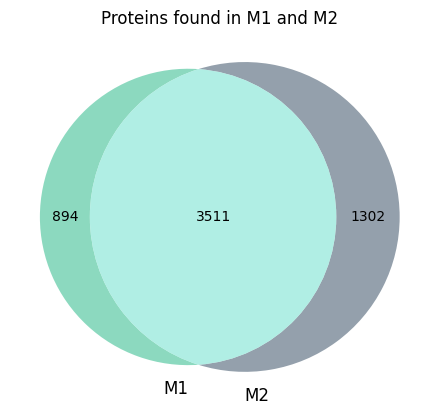

In [46]:
# Get the number of proteins in each dataset
n_proteins_M1 = len(dataM1)
n_proteins_M2 = len(dataM2)

# Get the number of proteins in common
common_proteins = dataM1.index.intersection(dataM2.index)
n_common_proteins = len(common_proteins)

# Create the Venn diagram plot
c = venn2(subsets=(n_proteins_M1 - n_common_proteins, n_proteins_M2 - n_common_proteins, n_common_proteins),
    set_labels=('M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey'), alpha=0.75)

# Add a title to the plot
plt.title('Proteins found in M1 and M2')

# Display the plot
plt.show()




In [47]:

# Check the number of NaN values in dataM1 and dataM2
print("Number of NaN values in dataM1")
print(dataM1.isnull().sum())
print("Number of NaN values in dataM2")
print(dataM2.isnull().sum())

# Create a copy by mergin dataM1 and dataM2 keeping the proteins present in only one of the datasets
merged_data = pd.merge(dataM1, dataM2, how='outer', on='Accession', suffixes=('_M1', '_M2'))
merged_data_original = merged_data.copy()
print(merged_data.isnull().sum())

merged_data['Description_M2'] = merged_data['Description_M2'].fillna('N/A')
merged_data['Description_M1'] = merged_data['Description_M1'].fillna('N/A')

# Replace missing values (NaN) with a very small value
merged_data.fillna(1e-1000, inplace=True)
print(merged_data.isnull().sum())

# Log fold change with the adjusted value
merged_data['Log2FC'] = np.log2(merged_data['# PSMs_M2'] + 1) - np.log2(merged_data['# PSMs_M1'] + 1)



Number of NaN values in dataM1
Description          0
Score                0
Coverage             0
# Proteins           0
# Unique Peptides    0
# Peptides           0
# PSMs               0
dtype: int64
Number of NaN values in dataM2
Description          0
Score                0
Coverage             0
# Proteins           0
# Unique Peptides    0
# Peptides           0
# PSMs               0
dtype: int64
Description_M1          1302
Score_M1                1302
Coverage_M1             1302
# Proteins_M1           1302
# Unique Peptides_M1    1302
# Peptides_M1           1302
# PSMs_M1               1302
Description_M2           894
Score_M2                 894
Coverage_M2              894
# Proteins_M2            894
# Unique Peptides_M2     894
# Peptides_M2            894
# PSMs_M2                894
dtype: int64
Description_M1          0
Score_M1                0
Coverage_M1             0
# Proteins_M1           0
# Unique Peptides_M1    0
# Peptides_M1           0
# PSMs_M1      

As we can observe, there is no missing value in the original dataset.

In [48]:
print(f"Number of 'N/A' in Description_M1: {merged_data[merged_data['Description_M1'] == 'N/A'].shape[0]}")
print(f"Number of 'N/A' in Description_M2: {merged_data[merged_data['Description_M2'] == 'N/A'].shape[0]}")

print(f"Number of proteins that are present in both datasets: {merged_data_original[merged_data_original['Description_M1'].notnull() & merged_data_original['Description_M2'].notnull()].shape[0]}")


Number of 'N/A' in Description_M1: 1302
Number of 'N/A' in Description_M2: 894
Number of proteins that are present in both datasets: 3511


In [49]:
# Add a 'class' column to the merged_data. 
merged_data['class'] = "Both"
merged_data.loc[(merged_data['Description_M1'] != 'N/A') & (merged_data['Description_M2'] == 'N/A'), 'class'] = "M1"
merged_data.loc[(merged_data['Description_M1'] == 'N/A') & (merged_data['Description_M2'] != 'N/A'), 'class'] = "M2"
print(merged_data['class'].value_counts())           



class
Both    3511
M2      1302
M1       894
Name: count, dtype: int64


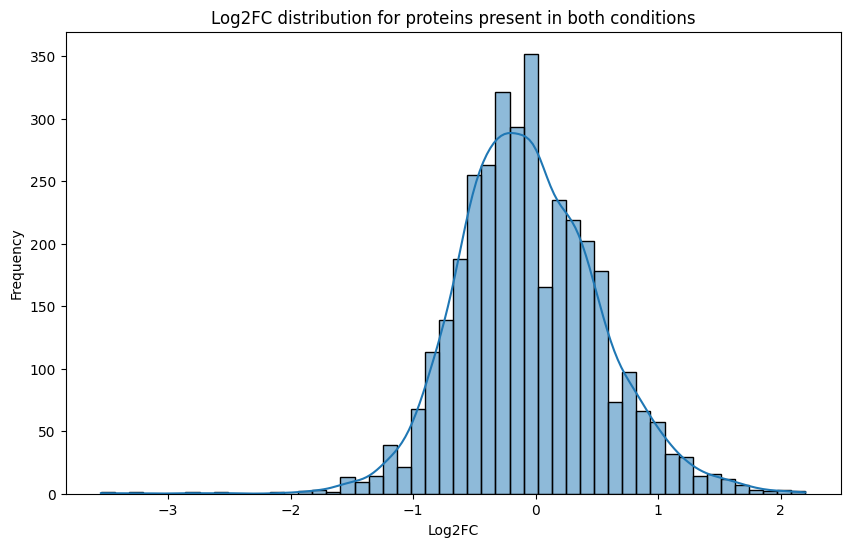

In [50]:
# Distribution of the log fold change for the class "Booth"
plt.figure(figsize=(10, 6))
sns.histplot(merged_data[merged_data['class'] == 'Both']['Log2FC'], bins=50, kde=True)
plt.title("Log2FC distribution for proteins present in both conditions")
plt.xlabel("Log2FC")
plt.ylabel("Frequency")
plt.show()   



Positive values in the 'Log2FC' column represent proteins that are more abundant in condition M2 compared to M1.<br>
Negative Log2FC values indicate proteins that are more abundant in condition M1 compared to M2.<br><br>
*Note that it was computed using #PSMs.*

In [51]:
# describe merged_data
print(merged_data.describe())

          Score_M1  Coverage_M1  # Proteins_M1  # Unique Peptides_M1  \
count  5707.000000  5707.000000    5707.000000           5707.000000   
mean     64.280995    18.643350       3.896969              6.139478   
std     158.714887    18.120073       4.421045              8.532191   
min       0.000000     0.000000       0.000000              0.000000   
25%       5.961427     3.295000       1.000000              1.000000   
50%      20.238535    14.200000       3.000000              4.000000   
75%      61.318732    28.840000       5.000000              8.000000   
max    3747.075588    94.740000      63.000000            276.000000   

       # Peptides_M1    # PSMs_M1     Score_M2  Coverage_M2  # Proteins_M2  \
count    5707.000000  5707.000000  5707.000000  5707.000000    5707.000000   
mean        6.948484    27.106185    65.479314    20.779066       4.277554   
std         9.468386    66.262883   139.456237    18.005178       4.737600   
min         0.000000     0.000000     0

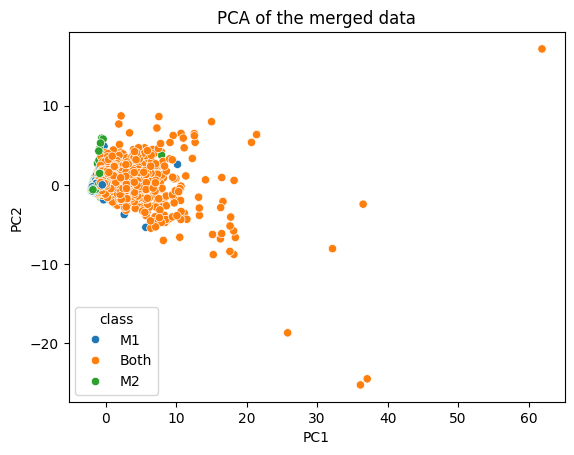

In [52]:
# Create the PCA object
pca = PCA(n_components=2)

# Create the StandardScaler object
scaler = StandardScaler()

# Fit the scaler
scaler.fit(merged_data.drop(columns=['Description_M1', 'Description_M2', 'Log2FC', 'class']))

# Transform the data
X = scaler.transform(merged_data.drop(columns=['Description_M1', 'Description_M2', 'Log2FC', 'class']))

# Fit the PCA
pca.fit(X)

# Transform the data
X_pca = pca.transform(X)

# Create a dataframe with the PCA values
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Add the class column
pca_df['class'] = merged_data['class'].values

# Plot the PCA
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class')
plt.title('PCA of the merged data')
plt.show()


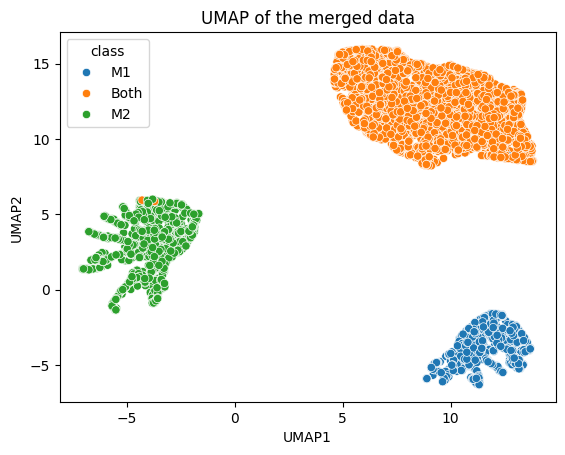

In [53]:
# Create the UMAP object
umap_obj = umap.UMAP()

# Fit the UMAP
umap_obj.fit(X)

# Transform the data
X_umap = umap_obj.transform(X)

# Create a dataframe with the UMAP values
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])

# Add the class column
umap_df['class'] = merged_data['class'].values

# Plot the UMAP
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='class')
plt.title('UMAP of the merged data')
plt.show()


In [54]:
# Initialize a list to store p-values
p_values = []

# Loop through each protein to calculate the p-value using Fisher's exact test
for index, row in merged_data.iterrows():
    # Create a 2x2 contingency table based on presence/absence in M1 and M2
    # Assumes 1 for present, 0 for absent
    if row['class'] == 'M1' or row['class'] == 'M2':
        present_m1 = 1 if row['class'] == 'M1' else 0
        present_m2 = 1 if row['class'] == 'M2' else 0

        # Contingency table format: [[present in M1, absent in M1], [present in M2, absent in M2]]
        contingency_table = [[present_m1, 1 - present_m1], [present_m2, 1 - present_m2]]
        
        # Perform Fisher's Exact Test
        _, p_val = fisher_exact(contingency_table)
        p_values.append(p_val)
    else:
        # If the protein is present in both or absent in both, assign a default p-value (e.g., 1)
        p_values.append(1.0)

# Add p-values to the dataframe
merged_data['p_value_class'] = p_values

# print unique p-values
print(f"Unique p-values (class): {len(set(p_values))}")



Unique p-values (class): 1


As **all p-values are 1**, it means that there is no significant difference between the two groups for any protein.
This make sense considering the chart with the PSM's (M1) vs PSM's (M2) 

# DEA

# Functional Enrichement

In [55]:

# Define thresholds
logFC_threshold = 1  # Threshold for log fold change (absolute value)
pval_threshold = 0.05  # Threshold for p-value

# Create a new column to categorize proteins based on thresholds
merged_data['significant'] = (merged_data['adjusted_p_value'] < pval_threshold) & (abs(merged_data['logFC_Proteins']) > logFC_threshold)

# Create volcano plot
plt.figure(figsize=(10, 7))

# Scatter plot for non-significant points (grey)
plt.scatter(merged_data['logFC_Proteins'], -np.log10(merged_data['adjusted_p_value']), c='grey', label='Non-significant')

# Highlight significant points (red for upregulated, blue for downregulated)
plt.scatter(merged_data.loc[(merged_data['logFC_Proteins'] > logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'logFC_Proteins'],
            -np.log10(merged_data.loc[(merged_data['logFC_Proteins'] > logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'adjusted_p_value']),
            c='red', label='Upregulated')

plt.scatter(merged_data.loc[(merged_data['logFC_Proteins'] < -logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'logFC_Proteins'],
            -np.log10(merged_data.loc[(merged_data['logFC_Proteins'] < -logFC_threshold) & (merged_data['adjusted_p_value'] < pval_threshold), 'adjusted_p_value']),
            c='blue', label='Downregulated')

# Add labels
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.title('Volcano Plot')

# Show legend
plt.legend()

# Show plot
plt.show()


KeyError: 'adjusted_p_value'

---

---


In [ ]:
# Join the dataM1 and dataM2 dataframes adding a column to identify the source of the data
dataM1['Source'] = 'M1'
dataM2['Source'] = 'M2'

# Concatenate the dataframes
data = pd.concat([dataM1, dataM2])

# Number of proteins in the concatenated dataframe
print(f"Number of proteins in the concatenated dataframe: {data.shape[0]}")

In [ ]:
# Perform a differential expression analysis without using scanpy

# Filter the proteins with a score higher than the threshold
data_filtered = data

# Number of proteins after filtering
print(f"Number of proteins after filtering: {data_filtered.shape[0]}")

# Perform a differential expression analysis
# Create a new column with the log2 fold change
data_filtered['log2FC'] = np.log2(data_filtered['# PSMs']/data_filtered['# PSMs'].mean())

# Create a new column with the p-value
data_filtered['p-value'] = 1 - data_filtered['Score']/data_filtered['Score'].max()

# Create a new column with the adjusted p-value
data_filtered['adj-p-value'] = data_filtered['p-value']

# Filter the proteins with an adjusted p-value lower than 0.05
data_filtered = data_filtered[data_filtered['adj-p-value'] < 0.05]

# Number of proteins after filtering
print(f"Number of proteins after filtering: {data_filtered.shape[0]}")

# Print the first 10 proteins
print(data_filtered.head(10))

# Perform a differential expression analysis using scanpy

# Create an AnnData object
adata = ad.AnnData(data_filtered)

# Perform a differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='Source', method='wilcoxon')

# Print the results
print(adata.uns['rank_genes_groups'])

# Perform a differential expression analysis using scanpy



In [ ]:
# Considering the TOP_NUMBER proteins in both M1 and M2, perform a differential expression analysis using the #PSMs as the feature to compare. Use the Wilcoxon test to compare the #PSMs of the proteins in M1 and M2. Plot the results in a volcano plot.
from scipy.stats import wilcoxon

# Perform the Wilcoxon test for each protein
p_values = []
for protein in common_proteins:
    p_values.append(wilcoxon(dataM1.loc[protein]['# PSMs'], dataM2.loc[protein]['# PSMs']).pvalue)

# Create a volcano plot
plt.figure(figsize=(12, 6))
plt.scatter(p_values, [0]*len(p_values), alpha=0.5)
plt.xlabel('p-value')
plt.ylabel('log2(fold-change)')
plt.title('Volcano plot')
plt.show()





              



In [ ]:
# Load the data
data_src = "./data/raw/sasha_SI_THP/SI_THP_RAW_proteomics_data_ss.xlsx"
dataM1 = pd.read_excel(data_src, sheet_name="THP_M1", index_col=0)
dataM2 = pd.read_excel(data_src, sheet_name="THP_M2", index_col=0)

# Concatenate the dataM1 and dataM2 vertically
data = pd.concat([dataM1, dataM2])

# Transpose the data
data = data.T

# Create an AnnData object with the data
adata = ad.AnnData(data.astype(np.float32))

# Add the cell type information to the adata object
cell_types = ['M1'] * dataM1.shape[0] + ['M2'] * dataM2.shape[0]
adata.obs['celltype'] = cell_types

# Perform PCA analysis
sc.tl.pca(adata)

# Plot PCA
sc.pl.pca(adata, color='celltype', size=60, title='PCA by cell type')


---

---

In [ ]:
# Load the data (Scanpy assumes that your columns are genes and your rows are cells)
data_src = "./data/spetch/proteins-processed.csv"
data = pd.read_csv(data_src, delimiter=",")

# Remove the last column
data = data.iloc[:, :-1]

# Transpose the data
data = data.T

# Keep the first row as the column names
proteins = data.iloc[0]

# Remove the first column
data = data.iloc[1:]

print(data)

# Create an AnnData object with the data
adata = ad.AnnData(data.astype(np.float32))

proteins = proteins.to_numpy()
adata.var['proteins'] = proteins

print(adata)


In [ ]:
# Load the anno.csv file with the cell type annotations
anno_src = "./data/spetch/cells.csv"
anno = pd.read_csv(anno_src, delimiter=",")

# Get the column names as cell IDs
cellID = anno.columns[1:]

# Transpose the data
anno = anno.T

celltypes = anno.loc[:, 0].values

# Remove the first element
celltypes = celltypes[1:]

# Create a new obs in the AnnData object with the cell type annotations 
adata.obs['cellID'] = cellID
adata.obs['celltype'] = celltypes



In [ ]:
print(adata)
print("---")
print(adata.X)

---
### Convert Protein ID to Gene names

In [ ]:
if TRANSLATE_PROTEIN_ID:
    # Convert proteins to gene names
    unipcl = UniprotClient()

    gene_names = unipcl.batch_translate_protein_ids(adata.var['proteins'])
    adata.var['gene_protein'] = [gene_names.get(i, i) for i in adata.var['proteins']]
    adata.var['gene'] = [i.split(' ')[0] for i in adata.var['gene_protein']]
    print(adata.var['proteins'])
    print(adata.var['gene_protein'])
    print(adata.var['gene'])


In [ ]:
adata_back = adata.copy()

---
### PCA & UMAP



In [ ]:
# PCA by cell type
sc.tl.pca(adata)
sc.pl.pca(adata, color='celltype', size=60, title='PCA by cell type')


In [ ]:
# UMAP by cell type
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype', size=60, title='UMAP by cell type')


---

In [ ]:
num_bins = 20

for celltype in adata.obs['celltype'].unique():
    plt.hist(adata[adata.obs['celltype'] == celltype].X.flatten(), bins=num_bins, alpha=0.5, label=celltype)

plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Protein Intensity distribution by Cell Type')

plt.legend()
plt.show()


In [ ]:

# Shift the matrix values so that all are positive
min_value = adata.X.min()
if min_value < 0:
    adata.X += np.abs(min_value) + 1  # Shift values to ensure they're all positive

# Filter to keep only the two groups you're interested in
group_1 = 'sc_m0'
group_2 = 'sc_u'

# Create a mask to filter the two groups
mask = adata.obs['celltype'].isin([group_1, group_2])
adata_filtered = adata[mask, :]

# Perform rank_genes_groups to find differentially expressed proteins between the two groups
sc.tl.rank_genes_groups(adata_filtered, 'celltype', groups=[group_1], reference=group_2, method='wilcoxon')

# Get log fold change and p-values
log2_fc = adata_filtered.uns['rank_genes_groups']['logfoldchanges'][group_1]  # Log2 fold changes
p_values = adata_filtered.uns['rank_genes_groups']['pvals'][group_1]          # p-values


# Convert p-values to -log10 for the volcano plot
log_p_values = -np.log10(p_values)

# Step 4: Create the volcano plot
volcano_data = pd.DataFrame({
    'log2_FC': log2_fc,
    '-log10_p_value': log_p_values
})

# Plotting the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(volcano_data['log2_FC'], volcano_data['-log10_p_value'], s=5)

# Add vertical lines to mark fold change threshold
plt.axvline(x=1, color='black', linestyle='--')  # Fold change threshold
plt.axvline(x=-1, color='black', linestyle='--')  # Fold change threshold

# Add horizontal lines to mark significance (e.g., p-value threshold)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')  # p-value threshold

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-value')
plt.title(f'Volcano Plot: {group_1} vs {group_2}')

plt.show()


### Experiments


In [ ]:
# Assuming adata is your AnnData object containing the intensity matrix
adata.X += 10  # Add a constant to ensure non-negativity
adata.X = adata.X / adata.X.max() * 1000  # Scale to a maximum count of 1000

# Sample from Poisson distribution to simulate count data
adata.X = np.random.poisson(adata.X)

adata.X = np.log2(adata.X + 1)  # Add 1 to avoid log of zero

In [ ]:
# Differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.pl.rank_genes_groups(adata)

In [ ]:
print(result)

In [ ]:

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
group1 = groups[0]
group2 = groups[1]

# Create DataFrame for easier handling
df = pd.DataFrame({
    'protein': result['names'][group1],
    f'logFC_{group1}': result['logfoldchanges'][group1],
    f'logFC_{group2}': result['logfoldchanges'][group2],
    f'pval_{group1}': result['pvals'][group1],
    f'pval_{group2}': result['pvals'][group2],
    f'pval_adj_{group1}': result['pvals_adj'][group1],
    f'pval_adj_{group2}': result['pvals_adj'][group2],
    f'score_{group1}': result['scores'][group1],
    f'score_{group2}': result['scores'][group2]
})

# Filter out entries with NaN log fold changes
df_filtered = df.dropna(subset=[f'logFC_{group1}', f'logFC_{group2}'])

# Print the filtered DataFrame
print(df_filtered.head())


In [ ]:

# Extract results for volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')


plt.show()

# Clustering and dendrogram
sc.tl.dendrogram(adata, groupby='celltype')
sc.pl.dendrogram(adata, groupby='celltype')

In [ ]:

# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()

In [ ]:
# Differential expression analysis with optional sparse matrix conversion
#sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')
sc.tl.rank_genes_groups(adata, 'celltype', method='wilcoxon')
# to visualize the results
sc.pl.rank_genes_groups(adata)

In [ ]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')

In [ ]:
# Extract results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals_adj = result['pvals_adj'][groups[0]]
logfoldchanges = result['logfoldchanges'][groups[0]]
gene_names = result['names'][groups[0]]

# Create DataFrame for plotting
volcano_df = pd.DataFrame({
    'protein': gene_names,
    'logFC': logfoldchanges,
    'p-adj': pvals_adj
})

# Volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=volcano_df, x='logFC', y=-np.log10(volcano_df['p-adj']),
                hue=np.log10(volcano_df['p-adj']) < -np.log10(0.05), palette={True: 'red', False: 'grey'}, legend=None)
plt.axhline(-np.log10(0.05), linestyle='--', color='black')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Volcano Plot')
plt.show()


In [ ]:
# Clustering
sc.tl.dendrogram(adata, groupby='celltype')

# Plot dendrogram
sc.pl.dendrogram(adata, groupby='celltype')
